In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import typhon
import utils
import datetime
import cartopy.crs as ccrs
from netCDF4 import Dataset
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams.update({'font.size': 15})


## Configure

In [2]:
platforms = ['BCO'] # specify platform e.g. BCO
date_bnds = [datetime.datetime(2020, 1, 20), datetime.datetime(2020, 2, 12)] # specify date period
time_period = ['0000', '2400'] # specify time period, use '0000'and '2400'for all soundings per day
branches = ['ascending'] # specify whether to use ascending or descending profiles (or both)
datapath = '/Users/u237022/Documents/EUREC4A/soundings/data/NC' # specify directory path containing sounding data (in netCDF format)
plot_dir = 'plots' # specify directory to save plots
n_smooth = 10 # Window size for smoothing of profiles

profile_variables = ['altitude', 'pressure', 'temperature', 'humidity', 'mixingRatio',\
                     'windSpeed', 'windDirection', 'dewPoint']
attribute_variables = ['latitude', 'longitude', 'time_of_launch_HHmmss', 'date_YYYYMMDD', 'platform_name']
variables = profile_variables + attribute_variables

## Read data 

In [3]:
date_range = []
if date_bnds[1] == date_bnds[0]:
    date_range = [date_bnds[0]]
else:
    d = date_bnds[0]
    while d <= date_bnds[1]:
        d = d + datetime.timedelta(days=1)
        date_range.append(d)
dates = [d.strftime('%Y%m%d') for d in date_range]
start_time = '0000' #time_period[0]
end_time = '2400'#time_period[1]
filenames = utils.get_filenames(dates, start_time, end_time, platforms, branches, datapath)

profiles = []
for n, filename in enumerate(filenames):
    profiles.append(utils.profiles_from_netcdf(os.path.join(datapath, filename), variables))

# Calculate relevant quantities

In [4]:
profiles_smoothed = utils.smooth_profiles(profiles, profile_variables, n_smooth)
for profile in profiles_smoothed:
    profile['launch_time'] = datetime.datetime(
        year = int(profile['date_YYYYMMDD'][0:4]),
        month = int(profile['date_YYYYMMDD'][4:6]),
        day = int(profile['date_YYYYMMDD'][6:8]),
        hour = int(profile['time_of_launch_HHmmss'][0:2]),
        minute = int(profile['time_of_launch_HHmmss'][2:4])
    )
    profile['vmr'] = typhon.physics.relative_humidity2vmr(
        profile['humidity'] * 1e-2,
        profile['pressure'] * 1e2,
        profile['temperature'] + 273.15    
    )
    profile['specific_humidity'] = typhon.physics.vmr2specific_humidity(
        profile['vmr']
    )
    profile['potTemp'] = utils.calc_potential_temperature(
        profile['temperature'] + 273.15,
        profile['pressure'] * 1e2
    )
    profile['virtPotTemp'] = utils.calc_virtual_potential_temperature(
        profile['temperature'] + 273.15,
        profile['mixingRatio'] * 1e-3,
        profile['pressure'] * 1e2
    )
    

profiles_smoothed = sorted(profiles_smoothed, key=lambda profile: profile['launch_time'])
heights = np.arange(0, 20e3, 4)
profiles_interp = utils.interpolate_profiles(profiles_smoothed, ['pressure', 'temperature', 'humidity', 'mixingRatio', 'windSpeed', 'windDirection', 'dewPoint', 'specific_humidity', 'potTemp', 'virtPotTemp'], heights)

/Users/u237022/opt/anaconda3/envs/field_campaign/lib/python3.7/site-packages/typhon/physics/thermodynamics.py:95: RuntimeWarning: invalid value encountered in less_equal
  if np.any(T <= 0):


# Temporal evolution

## Create arrays

In [5]:
plt.rcParams.update({'font.size': 17})
profile_arrays = {}
time_array = []
for var in profile_variables+['potTemp']:
    profile_arrays[var] = np.ones((len(profiles_interp), len(heights))) * np.nan
    for n, p in enumerate(profiles_interp):
        profile_arrays[var][n, :] = p[var]
        
for n, p in enumerate(profiles_interp):
    time_array.append(p['launch_time'])
time_array = np.asarray(time_array)
 

## Evolution of RH

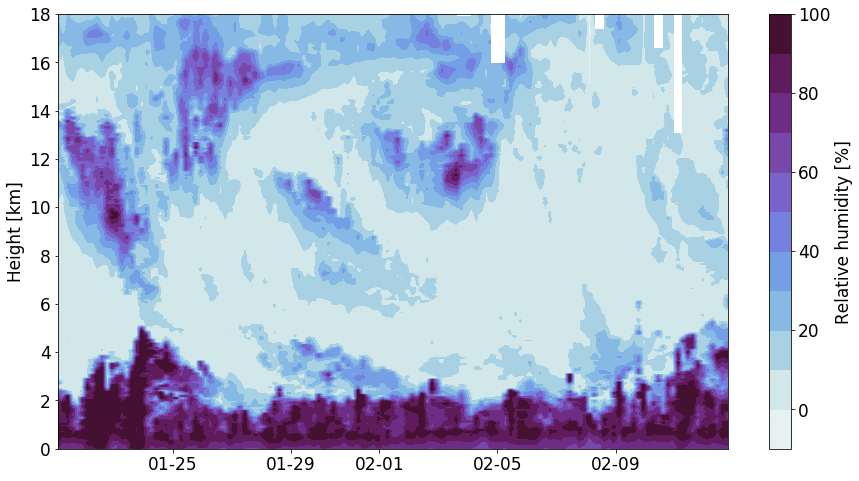

In [6]:
fig, ax = plt.subplots(figsize=(15, 8))
im = ax.contourf(time_array, heights * 1e-3, profile_arrays['humidity'].T, 10, vmin=0, vmax=100, cmap='density')
#ax.pcolor(time_array, heights * 1e-3, profile_arrays['humidity'].T, vmin=0, vmax=110, cmap='speed')
ax.set_ylim(0, 18)
#ax.set_ylim(0, 18)
myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(myFmt)
fig.colorbar(im, label='Relative humidity [%]')
ax.set_ylabel('Height [km]')
plt.savefig(os.path.join(plot_dir, 'BCO_RH_evolution.pdf'))
plt.savefig(os.path.join(plot_dir, 'BCO_RH_evolution.png'))

## Evolution of wind speed

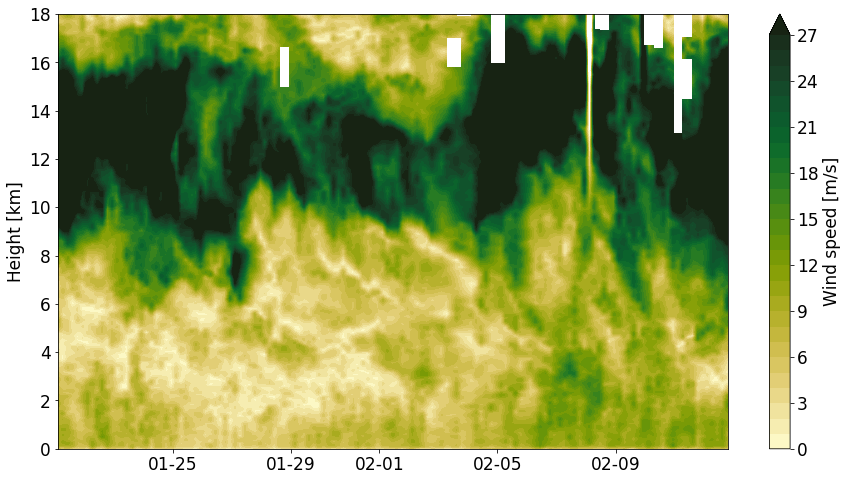

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))
im = ax.contourf(time_array, heights * 1e-3, profile_arrays['windSpeed'].T, np.arange(0, 28, 1), vmin=0, vmax=28, cmap='speed', extend='max')
#ax.pcolor(time_array, heights * 1e-3, profile_arrays['humidity'].T, vmin=0, vmax=110, cmap='speed')
ax.set_ylim(0, 18)
#ax.set_ylim(0, 18)
myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(myFmt)
fig.colorbar(im, label='Wind speed [m/s]')
ax.set_ylabel('Height [km]')
plt.savefig(os.path.join(plot_dir, 'BCO_Wspeed_evolution.pdf'))
plt.savefig(os.path.join(plot_dir, 'BCO_Wspeed_evolution.png'))

## Evolution of wind direction

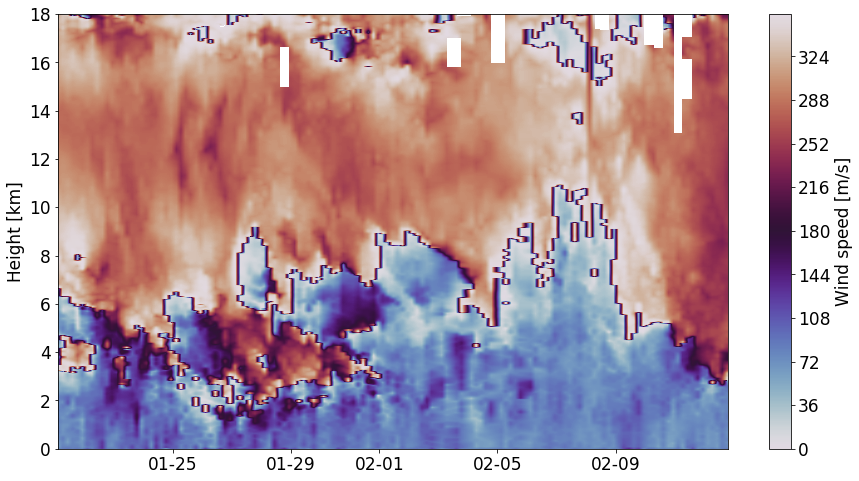

In [8]:
fig, ax = plt.subplots(figsize=(15, 8))
im = ax.contourf(time_array, heights * 1e-3, profile_arrays['windDirection'].T, np.arange(0, 360, 1), vmin=0, vmax=360, cmap='twilight')
#ax.pcolor(time_array, heights * 1e-3, profile_arrays['humidity'].T, vmin=0, vmax=110, cmap='speed')
ax.set_ylim(0, 18)
#ax.set_ylim(0, 18)
myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(myFmt)
fig.colorbar(im, label='Wind speed [m/s]')
ax.set_ylabel('Height [km]')
plt.savefig(os.path.join(plot_dir, 'BCO_Wdir_evolution.pdf'))
plt.savefig(os.path.join(plot_dir, 'BCO_Wdir_evolution.png'))